<a href="https://colab.research.google.com/github/sunandhini96/ERA_S9/blob/main/ERA_S9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Write a new network that
has the architecture to C1C2C3C40 (No MaxPooling, but 3 convolutions, where the last one has a stride of 2 instead) (If you can figure out how to use Dilated kernels here instead of MP or strided convolution, then 200pts extra!)
total RF must be more than 44

one of the layers must use Depthwise Separable Convolution

one of the layers must use Dilated Convolution

use GAP (compulsory):- add FC after GAP to target #of classes (optional)

use albumentation library and apply:
horizontal flip
shiftScaleRotate
coarseDropout (max_holes = 1, max_height=16px, max_width=16, min_holes = 1, min_height=16px, min_width=16px, fill_value=(mean of your dataset), mask_fill_value = None)

achieve 85% accuracy, as many epochs as you want. Total Params to be less than 200k.

In [1]:
!git clone https://github.com/katipallyvig8899/ERA_9.git

fatal: destination path 'ERA_9' already exists and is not an empty directory.


In [2]:
cd /content/ERA_9

/content/ERA_9


In [3]:
pwd

'/content/ERA_9'

In [4]:
!python model.py

## importing model

In [5]:
from model import *

In [6]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## defining train and test transformations

In [7]:

mean=(0.4914, 0.4822, 0.4465)
std=(0.2470, 0.2435, 0.2616)
def train_transform_function(mean,std):
    train_transform = A.Compose([A.Normalize(mean,std,always_apply=True),
                                 #A.PadIfNeeded(min_height=40,min_width=40,always_apply=True),
                                 #A.RandomCrop(height=32,width=32,always_apply=True),
                                 A.HorizontalFlip(),
                                 A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05,rotate_limit=15,p=0.5),
                                 A.CoarseDropout(max_holes=1,max_height=16,max_width=16, min_holes=1, min_height=16,min_width=16, fill_value=mean, mask_fill_value = None),
                                 ToTensorV2()

                                       ])
    return lambda img:train_transform(image=np.array(img))["image"]

In [8]:


# Test Phase transformations
def test_transform_function(mean,std):
      test_transform = A.Compose([
                                            #  transforms.Resize((28, 28)),
                                            #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),

                                            #transforms.ToTensor(),
                                            A.Normalize(mean,std),
                                            ToTensorV2()
                                            #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                            ])
      return lambda img:test_transform(image=np.array(img))["image"]


In [9]:
train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform_function(mean,std))
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform_function(mean,std))

Files already downloaded and verified
Files already downloaded and verified


In [10]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=1, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## Visualization

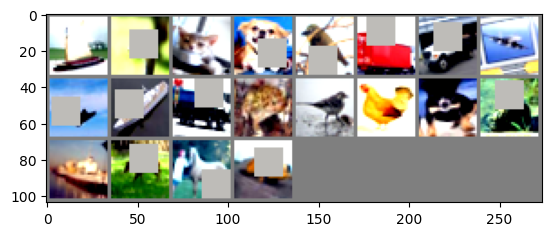

ship  bird  cat   dog   bird  truck truck plane plane ship  truck frog  bird  bird  dog   frog  ship  deer  horse truck


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:20]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(20)))

## Summary of the Model

In [12]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]             288
            Conv2d-6           [-1, 64, 32, 32]           2,048
depthwise_separable_conv-7           [-1, 64, 32, 32]               0
              ReLU-8           [-1, 64, 32, 32]               0
       BatchNorm2d-9           [-1, 64, 32, 32]             128
          Dropout-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 32, 16, 16]          18,432
           Conv2d-12           [-1, 64, 16, 16]          18,432
             ReLU-13           [-1, 64, 16, 16]               0
      BatchNorm2d-14        

## Training the model

In [13]:
from model import train,test

In [14]:
from torch.optim.lr_scheduler import StepLR
#from torch_lr_finder import LRFinder

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 75
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    #scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.4915597438812256 Batch_id=97 Accuracy=32.40: 100%|██████████| 98/98 [00:24<00:00,  4.03it/s]



Test set: Average loss: 1.4975, Accuracy: 4493/10000 (44.93%)

EPOCH: 1


Loss=1.3821922540664673 Batch_id=97 Accuracy=45.29: 100%|██████████| 98/98 [00:17<00:00,  5.58it/s]



Test set: Average loss: 1.3361, Accuracy: 5125/10000 (51.25%)

EPOCH: 2


Loss=1.3359240293502808 Batch_id=97 Accuracy=50.97: 100%|██████████| 98/98 [00:15<00:00,  6.19it/s]



Test set: Average loss: 1.1881, Accuracy: 5750/10000 (57.50%)

EPOCH: 3


Loss=1.1243011951446533 Batch_id=97 Accuracy=55.58: 100%|██████████| 98/98 [00:15<00:00,  6.20it/s]



Test set: Average loss: 1.0446, Accuracy: 6253/10000 (62.53%)

EPOCH: 4


Loss=1.1407073736190796 Batch_id=97 Accuracy=58.53: 100%|██████████| 98/98 [00:15<00:00,  6.26it/s]



Test set: Average loss: 1.0233, Accuracy: 6370/10000 (63.70%)

EPOCH: 5


Loss=1.082513689994812 Batch_id=97 Accuracy=61.01: 100%|██████████| 98/98 [00:17<00:00,  5.73it/s]



Test set: Average loss: 0.9129, Accuracy: 6799/10000 (67.99%)

EPOCH: 6


Loss=1.1115024089813232 Batch_id=97 Accuracy=63.15: 100%|██████████| 98/98 [00:15<00:00,  6.15it/s]



Test set: Average loss: 0.8337, Accuracy: 7061/10000 (70.61%)

EPOCH: 7


Loss=0.9960179328918457 Batch_id=97 Accuracy=65.19: 100%|██████████| 98/98 [00:15<00:00,  6.15it/s]



Test set: Average loss: 0.8178, Accuracy: 7115/10000 (71.15%)

EPOCH: 8


Loss=0.9523574113845825 Batch_id=97 Accuracy=66.69: 100%|██████████| 98/98 [00:16<00:00,  5.90it/s]



Test set: Average loss: 0.7933, Accuracy: 7269/10000 (72.69%)

EPOCH: 9


Loss=0.9188832640647888 Batch_id=97 Accuracy=67.98: 100%|██████████| 98/98 [00:15<00:00,  6.15it/s]



Test set: Average loss: 0.7601, Accuracy: 7375/10000 (73.75%)

EPOCH: 10


Loss=0.9434088468551636 Batch_id=97 Accuracy=68.79: 100%|██████████| 98/98 [00:16<00:00,  5.78it/s]



Test set: Average loss: 0.7107, Accuracy: 7559/10000 (75.59%)

EPOCH: 11


Loss=0.9221489429473877 Batch_id=97 Accuracy=70.26: 100%|██████████| 98/98 [00:16<00:00,  6.11it/s]



Test set: Average loss: 0.6988, Accuracy: 7547/10000 (75.47%)

EPOCH: 12


Loss=0.886305034160614 Batch_id=97 Accuracy=70.59: 100%|██████████| 98/98 [00:16<00:00,  5.83it/s]



Test set: Average loss: 0.7269, Accuracy: 7475/10000 (74.75%)

EPOCH: 13


Loss=0.7853302955627441 Batch_id=97 Accuracy=71.42: 100%|██████████| 98/98 [00:15<00:00,  6.13it/s]



Test set: Average loss: 0.6757, Accuracy: 7613/10000 (76.13%)

EPOCH: 14


Loss=0.8721885681152344 Batch_id=97 Accuracy=71.91: 100%|██████████| 98/98 [00:17<00:00,  5.70it/s]



Test set: Average loss: 0.6334, Accuracy: 7831/10000 (78.31%)

EPOCH: 15


Loss=0.7707821130752563 Batch_id=97 Accuracy=72.60: 100%|██████████| 98/98 [00:16<00:00,  6.12it/s]



Test set: Average loss: 0.6199, Accuracy: 7864/10000 (78.64%)

EPOCH: 16


Loss=0.7173089981079102 Batch_id=97 Accuracy=73.32: 100%|██████████| 98/98 [00:15<00:00,  6.20it/s]



Test set: Average loss: 0.6104, Accuracy: 7899/10000 (78.99%)

EPOCH: 17


Loss=0.9216620326042175 Batch_id=97 Accuracy=73.39: 100%|██████████| 98/98 [00:16<00:00,  6.12it/s]



Test set: Average loss: 0.6134, Accuracy: 7933/10000 (79.33%)

EPOCH: 18


Loss=0.6862179040908813 Batch_id=97 Accuracy=73.70: 100%|██████████| 98/98 [00:15<00:00,  6.15it/s]



Test set: Average loss: 0.6042, Accuracy: 7912/10000 (79.12%)

EPOCH: 19


Loss=0.6751086711883545 Batch_id=97 Accuracy=74.18: 100%|██████████| 98/98 [00:16<00:00,  5.94it/s]



Test set: Average loss: 0.6036, Accuracy: 7918/10000 (79.18%)

EPOCH: 20


Loss=0.6841354370117188 Batch_id=97 Accuracy=74.79: 100%|██████████| 98/98 [00:16<00:00,  6.12it/s]



Test set: Average loss: 0.5619, Accuracy: 8076/10000 (80.76%)

EPOCH: 21


Loss=0.904085636138916 Batch_id=97 Accuracy=75.47: 100%|██████████| 98/98 [00:16<00:00,  5.78it/s]



Test set: Average loss: 0.5691, Accuracy: 8064/10000 (80.64%)

EPOCH: 22


Loss=0.6096150279045105 Batch_id=97 Accuracy=75.62: 100%|██████████| 98/98 [00:15<00:00,  6.20it/s]



Test set: Average loss: 0.5470, Accuracy: 8122/10000 (81.22%)

EPOCH: 23


Loss=0.7908405065536499 Batch_id=97 Accuracy=76.15: 100%|██████████| 98/98 [00:16<00:00,  5.83it/s]



Test set: Average loss: 0.5469, Accuracy: 8160/10000 (81.60%)

EPOCH: 24


Loss=0.6451444625854492 Batch_id=97 Accuracy=76.09: 100%|██████████| 98/98 [00:16<00:00,  6.12it/s]



Test set: Average loss: 0.5364, Accuracy: 8177/10000 (81.77%)

EPOCH: 25


Loss=0.667016863822937 Batch_id=97 Accuracy=76.84: 100%|██████████| 98/98 [00:16<00:00,  5.99it/s]



Test set: Average loss: 0.5299, Accuracy: 8194/10000 (81.94%)

EPOCH: 26


Loss=0.7062538862228394 Batch_id=97 Accuracy=76.76: 100%|██████████| 98/98 [00:16<00:00,  6.10it/s]



Test set: Average loss: 0.5337, Accuracy: 8180/10000 (81.80%)

EPOCH: 27


Loss=0.6929542422294617 Batch_id=97 Accuracy=76.92: 100%|██████████| 98/98 [00:17<00:00,  5.69it/s]



Test set: Average loss: 0.5131, Accuracy: 8248/10000 (82.48%)

EPOCH: 28


Loss=0.7163329124450684 Batch_id=97 Accuracy=77.24: 100%|██████████| 98/98 [00:16<00:00,  6.10it/s]



Test set: Average loss: 0.5353, Accuracy: 8181/10000 (81.81%)

EPOCH: 29


Loss=0.5841047167778015 Batch_id=97 Accuracy=77.43: 100%|██████████| 98/98 [00:16<00:00,  6.10it/s]



Test set: Average loss: 0.5154, Accuracy: 8234/10000 (82.34%)

EPOCH: 30


Loss=0.6236026883125305 Batch_id=97 Accuracy=77.74: 100%|██████████| 98/98 [00:15<00:00,  6.24it/s]



Test set: Average loss: 0.4963, Accuracy: 8269/10000 (82.69%)

EPOCH: 31


Loss=0.6525227427482605 Batch_id=97 Accuracy=78.07: 100%|██████████| 98/98 [00:15<00:00,  6.17it/s]



Test set: Average loss: 0.5154, Accuracy: 8223/10000 (82.23%)

EPOCH: 32


Loss=0.5999318361282349 Batch_id=97 Accuracy=78.31: 100%|██████████| 98/98 [00:16<00:00,  5.91it/s]



Test set: Average loss: 0.4991, Accuracy: 8283/10000 (82.83%)

EPOCH: 33


Loss=0.6558102369308472 Batch_id=97 Accuracy=78.37: 100%|██████████| 98/98 [00:16<00:00,  5.85it/s]



Test set: Average loss: 0.4911, Accuracy: 8330/10000 (83.30%)

EPOCH: 34


Loss=0.5523566603660583 Batch_id=97 Accuracy=78.44: 100%|██████████| 98/98 [00:16<00:00,  5.97it/s]



Test set: Average loss: 0.5029, Accuracy: 8314/10000 (83.14%)

EPOCH: 35


Loss=0.5584487915039062 Batch_id=97 Accuracy=78.95: 100%|██████████| 98/98 [00:15<00:00,  6.14it/s]



Test set: Average loss: 0.5101, Accuracy: 8283/10000 (82.83%)

EPOCH: 36


Loss=0.6428347826004028 Batch_id=97 Accuracy=78.90: 100%|██████████| 98/98 [00:16<00:00,  5.82it/s]



Test set: Average loss: 0.4952, Accuracy: 8295/10000 (82.95%)

EPOCH: 37


Loss=0.5595013499259949 Batch_id=97 Accuracy=79.11: 100%|██████████| 98/98 [00:15<00:00,  6.21it/s]



Test set: Average loss: 0.4894, Accuracy: 8357/10000 (83.57%)

EPOCH: 38


Loss=0.5535809993743896 Batch_id=97 Accuracy=79.50: 100%|██████████| 98/98 [00:16<00:00,  6.03it/s]



Test set: Average loss: 0.4663, Accuracy: 8399/10000 (83.99%)

EPOCH: 39


Loss=0.6060337424278259 Batch_id=97 Accuracy=79.37: 100%|██████████| 98/98 [00:15<00:00,  6.20it/s]



Test set: Average loss: 0.4636, Accuracy: 8448/10000 (84.48%)

EPOCH: 40


Loss=0.6057236194610596 Batch_id=97 Accuracy=79.42: 100%|██████████| 98/98 [00:16<00:00,  5.84it/s]



Test set: Average loss: 0.4971, Accuracy: 8295/10000 (82.95%)

EPOCH: 41


Loss=0.6124333739280701 Batch_id=97 Accuracy=79.60: 100%|██████████| 98/98 [00:16<00:00,  6.02it/s]



Test set: Average loss: 0.4684, Accuracy: 8431/10000 (84.31%)

EPOCH: 42


Loss=0.5350590944290161 Batch_id=97 Accuracy=79.82: 100%|██████████| 98/98 [00:15<00:00,  6.25it/s]



Test set: Average loss: 0.4533, Accuracy: 8448/10000 (84.48%)

EPOCH: 43


Loss=0.6030251383781433 Batch_id=97 Accuracy=79.96: 100%|██████████| 98/98 [00:16<00:00,  5.86it/s]



Test set: Average loss: 0.4590, Accuracy: 8453/10000 (84.53%)

EPOCH: 44


Loss=0.5412190556526184 Batch_id=97 Accuracy=80.26: 100%|██████████| 98/98 [00:15<00:00,  6.23it/s]



Test set: Average loss: 0.4473, Accuracy: 8474/10000 (84.74%)

EPOCH: 45


Loss=0.5583840608596802 Batch_id=97 Accuracy=80.33: 100%|██████████| 98/98 [00:16<00:00,  5.93it/s]



Test set: Average loss: 0.4692, Accuracy: 8415/10000 (84.15%)

EPOCH: 46


Loss=0.6256952881813049 Batch_id=97 Accuracy=80.69: 100%|██████████| 98/98 [00:16<00:00,  5.81it/s]



Test set: Average loss: 0.4569, Accuracy: 8439/10000 (84.39%)

EPOCH: 47


Loss=0.5662943720817566 Batch_id=97 Accuracy=80.53: 100%|██████████| 98/98 [00:15<00:00,  6.13it/s]



Test set: Average loss: 0.4529, Accuracy: 8479/10000 (84.79%)

EPOCH: 48


Loss=0.5162205696105957 Batch_id=97 Accuracy=80.57: 100%|██████████| 98/98 [00:15<00:00,  6.17it/s]



Test set: Average loss: 0.4426, Accuracy: 8471/10000 (84.71%)

EPOCH: 49


Loss=0.6257697343826294 Batch_id=97 Accuracy=80.84: 100%|██████████| 98/98 [00:15<00:00,  6.20it/s]



Test set: Average loss: 0.4421, Accuracy: 8509/10000 (85.09%)

EPOCH: 50


Loss=0.5082882642745972 Batch_id=97 Accuracy=80.98: 100%|██████████| 98/98 [00:16<00:00,  5.98it/s]



Test set: Average loss: 0.4704, Accuracy: 8390/10000 (83.90%)

EPOCH: 51


Loss=0.5675469040870667 Batch_id=97 Accuracy=80.93: 100%|██████████| 98/98 [00:16<00:00,  6.10it/s]



Test set: Average loss: 0.4386, Accuracy: 8508/10000 (85.08%)

EPOCH: 52


Loss=0.509354293346405 Batch_id=97 Accuracy=81.15: 100%|██████████| 98/98 [00:16<00:00,  5.84it/s]



Test set: Average loss: 0.4212, Accuracy: 8592/10000 (85.92%)

EPOCH: 53


Loss=0.4793517589569092 Batch_id=97 Accuracy=81.49: 100%|██████████| 98/98 [00:16<00:00,  6.10it/s]



Test set: Average loss: 0.4442, Accuracy: 8476/10000 (84.76%)

EPOCH: 54


Loss=0.5309321284294128 Batch_id=97 Accuracy=81.47: 100%|██████████| 98/98 [00:16<00:00,  5.83it/s]



Test set: Average loss: 0.4358, Accuracy: 8526/10000 (85.26%)

EPOCH: 55


Loss=0.5187520384788513 Batch_id=97 Accuracy=81.57: 100%|██████████| 98/98 [00:15<00:00,  6.13it/s]



Test set: Average loss: 0.4443, Accuracy: 8501/10000 (85.01%)

EPOCH: 56


Loss=0.4955766797065735 Batch_id=97 Accuracy=81.63: 100%|██████████| 98/98 [00:16<00:00,  5.78it/s]



Test set: Average loss: 0.4433, Accuracy: 8514/10000 (85.14%)

EPOCH: 57


Loss=0.5977346301078796 Batch_id=97 Accuracy=81.84: 100%|██████████| 98/98 [00:16<00:00,  6.09it/s]



Test set: Average loss: 0.4278, Accuracy: 8570/10000 (85.70%)

EPOCH: 58


Loss=0.49245572090148926 Batch_id=97 Accuracy=81.63: 100%|██████████| 98/98 [00:16<00:00,  5.91it/s]



Test set: Average loss: 0.4300, Accuracy: 8556/10000 (85.56%)

EPOCH: 59


Loss=0.5187042951583862 Batch_id=97 Accuracy=81.86: 100%|██████████| 98/98 [00:17<00:00,  5.73it/s]



Test set: Average loss: 0.4297, Accuracy: 8579/10000 (85.79%)

EPOCH: 60


Loss=0.47050735354423523 Batch_id=97 Accuracy=81.86: 100%|██████████| 98/98 [00:16<00:00,  5.89it/s]



Test set: Average loss: 0.4477, Accuracy: 8481/10000 (84.81%)

EPOCH: 61


Loss=0.4407059848308563 Batch_id=97 Accuracy=82.13: 100%|██████████| 98/98 [00:16<00:00,  6.08it/s]



Test set: Average loss: 0.4287, Accuracy: 8540/10000 (85.40%)

EPOCH: 62


Loss=0.5311897397041321 Batch_id=97 Accuracy=82.41: 100%|██████████| 98/98 [00:16<00:00,  6.01it/s]



Test set: Average loss: 0.4189, Accuracy: 8576/10000 (85.76%)

EPOCH: 63


Loss=0.3777085244655609 Batch_id=97 Accuracy=82.26: 100%|██████████| 98/98 [00:15<00:00,  6.13it/s]



Test set: Average loss: 0.4167, Accuracy: 8586/10000 (85.86%)

EPOCH: 64


Loss=0.5041196346282959 Batch_id=97 Accuracy=82.42: 100%|██████████| 98/98 [00:15<00:00,  6.13it/s]



Test set: Average loss: 0.4115, Accuracy: 8581/10000 (85.81%)

EPOCH: 65


Loss=0.44445499777793884 Batch_id=97 Accuracy=82.23: 100%|██████████| 98/98 [00:16<00:00,  5.83it/s]



Test set: Average loss: 0.4147, Accuracy: 8601/10000 (86.01%)

EPOCH: 66


Loss=0.41775989532470703 Batch_id=97 Accuracy=82.50: 100%|██████████| 98/98 [00:16<00:00,  6.08it/s]



Test set: Average loss: 0.4204, Accuracy: 8593/10000 (85.93%)

EPOCH: 67


Loss=0.5181791186332703 Batch_id=97 Accuracy=82.69: 100%|██████████| 98/98 [00:16<00:00,  5.95it/s]



Test set: Average loss: 0.4108, Accuracy: 8598/10000 (85.98%)

EPOCH: 68


Loss=0.5649653673171997 Batch_id=97 Accuracy=82.68: 100%|██████████| 98/98 [00:16<00:00,  6.10it/s]



Test set: Average loss: 0.4108, Accuracy: 8626/10000 (86.26%)

EPOCH: 69


Loss=0.5153646469116211 Batch_id=97 Accuracy=82.35: 100%|██████████| 98/98 [00:16<00:00,  5.82it/s]



Test set: Average loss: 0.4075, Accuracy: 8624/10000 (86.24%)

EPOCH: 70


Loss=0.5925967693328857 Batch_id=97 Accuracy=82.84: 100%|██████████| 98/98 [00:15<00:00,  6.23it/s]



Test set: Average loss: 0.4155, Accuracy: 8612/10000 (86.12%)

EPOCH: 71


Loss=0.49762362241744995 Batch_id=97 Accuracy=83.14: 100%|██████████| 98/98 [00:16<00:00,  5.84it/s]



Test set: Average loss: 0.4096, Accuracy: 8607/10000 (86.07%)

EPOCH: 72


Loss=0.47561898827552795 Batch_id=97 Accuracy=82.89: 100%|██████████| 98/98 [00:16<00:00,  6.12it/s]



Test set: Average loss: 0.4088, Accuracy: 8629/10000 (86.29%)

EPOCH: 73


Loss=0.47508707642555237 Batch_id=97 Accuracy=82.79: 100%|██████████| 98/98 [00:16<00:00,  5.94it/s]



Test set: Average loss: 0.4132, Accuracy: 8617/10000 (86.17%)

EPOCH: 74


Loss=0.5418494343757629 Batch_id=97 Accuracy=82.93: 100%|██████████| 98/98 [00:16<00:00,  6.03it/s]



Test set: Average loss: 0.4094, Accuracy: 8654/10000 (86.54%)



In [15]:
model

Net(
  (convblock1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock2): Sequential(
    (0): depthwise_separable_conv(
      (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=32, bias=False)
      (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.05, inplace=False)
  )
  (convblock3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), dilation=(2, 2), bias=False)
  )
  (convblock4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [16]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list

model_children = model.children()
for children in model_children:
    if type(children) == nn.Sequential:
        for child in children:
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)

print(f"Total convolution layers: {counter}")
# print("conv_layers")

Total convolution layers: 9


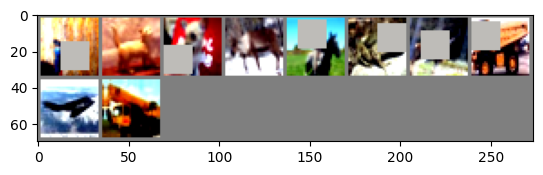

In [17]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:10]))

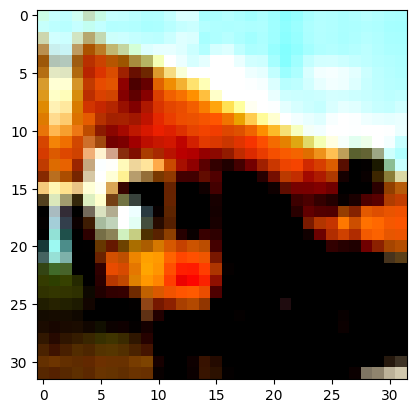

In [18]:
image = images[9]
imshow(image)

In [19]:
image = image.unsqueeze(0)
image = image.to(device)

## Loss and Accuracy curves

Text(0.5, 1.0, 'Test Accuracy')

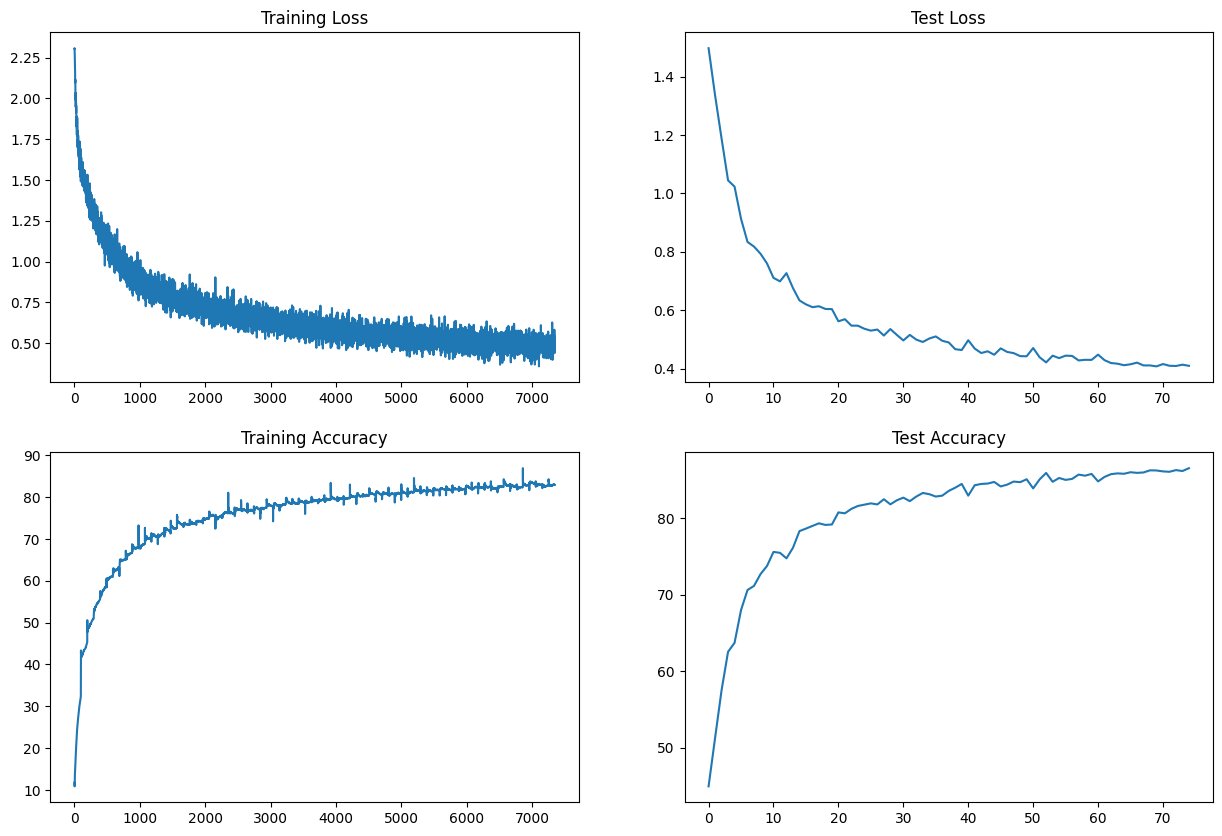

In [20]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
t=[t.cpu().item() for t in train_losses]
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")